# Investigate temperature change potential of different aerosol forcing time series


### Figure sizing
AGU’s goal is for the text size of the labeling in each figure to match the text size in the body of the article. This means that for most AGU journals, text and labeling in a figure should be 8 points at the final printing size. Subscript and superscript should be 6 points.

All information within the figure, including symbols, legends, characters, patterns, and shading, must be legible at the final size. Figures should be sized between:

1/4 page figure = 95 mm x 115 mm
Full page = 190 mm x 230 mm

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as pl
import os
import urllib
import json
import wquantiles
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from scipy.optimize import root
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
import random
import h5py
from zipfile import ZipFile
from climateforcing.twolayermodel import TwoLayerModel

In [2]:
# hdf5 utilities
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item.value
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
    return ans


# get my data
def check_and_download(filepath, url):
    """Checks prescence of a file and downloads if not present.

    Inputs
    ------
        filepath : str
            filename to download to
        url :
            url to download from
    """
    if not os.path.isfile(filepath):
        urllib.request.urlretrieve(url, filepath)
    return

In [3]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

## von Schuckmann ocean heat uptake

the citation is https://www.earth-syst-sci-data-discuss.net/essd-2019-255/

In [4]:
nc = Dataset('../data_input/GCOS_all_heat_content_1960-2018_ZJ_v22062020.nc')
#print(nc.variables)
ohctop = nc.variables['ohc_0-2000m'][:]
ohcbot = nc.variables['ohc_below_2000m'][:]
atmosh = nc.variables['atmospheric_heat_content'][:]
cryosh = nc.variables['energy_cryosphere'][:]
landhc = nc.variables['ground_heat_content'][:]
ohctopu = nc.variables['ohc_0-2000m_uncertainty'][:]
ohcbotu = nc.variables['ohc_below_2000m_uncertainty'][:]
atmoshu = nc.variables['atmospheric_heat_content_uncertainty'][:]
cryoshu = nc.variables['energy_cryosphere_uncertainty'][:]
landhcu = nc.variables['ground_heat_content_uncertainty'][:]
nc.close()
cryosh[-1] = cryosh[-2]  # nan for 2017-2018, assume no change
cryoshu[-1] = cryoshu[-2]
OHCobs = (ohctop+ohcbot+atmosh+cryosh+landhc)-(ohctop+ohcbot+atmosh+cryosh+landhc)[11]
print(OHCobs[-1])
#OHCobs_u = np.sqrt(ohctopu**2 + ohcbotu**2 + atmoshu**2 + cryoshu**2 + landhcu**2)
#pl.fill_between(np.arange(1960.5, 2019), OHCobs - 2 * OHCobs_u, OHCobs + 2 * OHCobs_u, alpha=0.3)
#pl.plot(np.arange(1960.5,2019), OHCobs)

361.4982


## Non-aerosol forcing is based on SSP2-4.5

- externally supplied and could be updated when AR6 approved
- this is an update of the RCMIP time series

In [5]:
ssp245_allforcing = pd.read_csv('../data_input/ERF_ssp245_1750-2500.csv')
baseline_forcing = ssp245_allforcing[:270].copy()

baseline_forcing.drop(
    labels=['total_anthropogenic','total'],
    axis='columns',
    inplace=True
)
baseline_forcing['total_anthropogenic'] = baseline_forcing[['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','aerosol-radiation_interactions','aerosol-cloud_interactions']].sum(axis=1)
baseline_forcing['total'] = baseline_forcing['total_anthropogenic'] + baseline_forcing['total_natural']
baseline_forcing.set_index('year', inplace=True)
pd.set_option('display.max_rows', 999)
baseline_forcing

,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_natural,total_anthropogenic,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.206975,0.073621,0.280596,0.000000,0.280596
1751,0.000810,0.000280,0.000107,0.000000e+00,0.000300,0.000000,0.000026,0.000000e+00,0.001931,0.004336,-0.000288,-0.000229,0.206987,0.055275,0.262262,0.007271,0.269534
1752,0.001619,0.000966,0.000228,0.000000e+00,0.000600,0.000000,0.000088,0.000000e+00,0.003311,0.006756,-0.000388,-0.000458,0.206991,0.025197,0.232188,0.012724,0.244912
1753,0.002291,0.001441,0.000397,0.000000e+00,0.000900,0.000000,0.000132,0.000000e+00,0.001950,0.004411,-0.000299,-0.000687,0.206993,-0.010981,0.196012,0.010535,0.206547
1754,0.003100,0.001808,0.000555,0.000000e+00,0.001200,0.000000,0.000165,0.000000e+00,-0.001233,-0.001820,0.000018,-0.000916,0.206993,-0.045395,0.161598,0.002876,0.164474
1755,0.004028,0.002153,0.000683,0.000000e+00,0.001500,0.000000,0.000197,0.000000e+00,0.001036,0.001222,0.000016,-0.001145,0.180025,-0.069873,0.110152,0.009689,0.119841
1756,0.004778,0.002595,0.000786,0.000000e+00,0.001800,0.000000,0.000237,0.000000e+00,0.001650,0.004177,-0.000334,-0.001374,-0.070676,-0.077455,-0.148131,0.014313,-0.133817
1757,0.005824,0.002899,0.000848,0.000000e+00,0.002100,0.000000,0.000265,0.000000e+00,-0.000985,-0.005024,0.000581,-0.001604,0.073348,-0.058313,0.015035,0.004904,0.019939
1758,0.006751,0.003102,0.000970,0.000000e+00,0.002400,0.000000,0.000283,0.000000e+00,0.000073,-0.001664,0.000265,-0.001833,0.160265,-0.006956,0.153309,0.010346,0.163656


In [6]:
# Model-specific ERF datasets
CanESM5_aerforcing = pd.read_csv('../data_output/rfmip_aprp/CanESM5.csv')
E3SM_aerforcing = pd.read_csv('../data_output/rfmip_aprp/E3SM.csv')
GISS_aerforcing = pd.read_csv('../data_output/rfmip_aprp/GISS-E2-1-G.csv')
HadGEM3_aerforcing = pd.read_csv('../data_output/rfmip_aprp/HadGEM3-GC31-LL.csv')
MIROC6_aerforcing = pd.read_csv('../data_output/rfmip_aprp/MIROC6.csv')
GFDL_aerforcing = pd.read_csv('../data_output/rfmip_aprp/GFDL-CM4.csv')
GFDLESM_aerforcing = pd.read_csv('../data_output/rfmip_aprp/GFDL-ESM4.csv')
NorESM2_aerforcing = pd.read_csv('../data_output/rfmip_aprp/NorESM2-LM.csv')
UKESM_aerforcing = pd.read_csv('../data_output/rfmip_aprp/UKESM1-0-LL.csv')
IPSL_aerforcing = pd.read_csv('../data_output/rfmip_aprp/IPSL-CM6A-LR.csv')
MRI_aerforcing = pd.read_csv('../data_output/rfmip_aprp/MRI-ESM2-0.csv')

# Lund et al., 2019, ACP: (details in supplement)
# https://www.atmos-chem-phys.net/19/13827/2019/acp-19-13827-2019-supplement.pdf
# we use SSP2-4.5 for extension
Lund_rfacipoints = [0, -0.03, -0.08, -0.12, -0.13, -0.15, -0.17, -0.21, -0.26, -0.33, -0.38, -0.37,
                    -0.40, -0.44, -0.40, -0.45, -0.44, -0.44, -0.42, -0.36, -0.35, -0.26, -0.11]
Lund_rfaripoints = [0, 0.002, -0.03, -0.05, -0.06, -0.06, -0.08, -0.10, -0.14, -0.24, -0.26, -0.24,
                    -0.24, -0.22, -0.19, -0.20, -0.17, -0.17, -0.13, -0.10, -0.13, -0.09, -0.09]
Lund_timepoints  = [1750, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1985, 1990, 1995,
                    2000, 2005, 2010, 2014, 2015, 2020, 2030, 2050, 2100]
f = interp1d(Lund_timepoints, np.array(Lund_rfacipoints)+np.array(Lund_rfaripoints))
Lund_aerforcing = f(np.arange(1750,2101))
f = interp1d(Lund_timepoints, np.array(Lund_rfaripoints))
Lund_ERFari = f(np.arange(1750,2101))
f = interp1d(Lund_timepoints, np.array(Lund_rfacipoints))
Lund_ERFaci = f(np.arange(1750,2101))

In [7]:
baseline_forcing.index

Int64Index([1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759,
            ...
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64', name='year', length=270)

In [8]:
# Temperature (GMST) observations: Cowtan and Way, accessed 24 November 2020
cw_temp = np.loadtxt('../data_input/CW.txt')

-0.0005179520184544435
1.0972445294117645


170

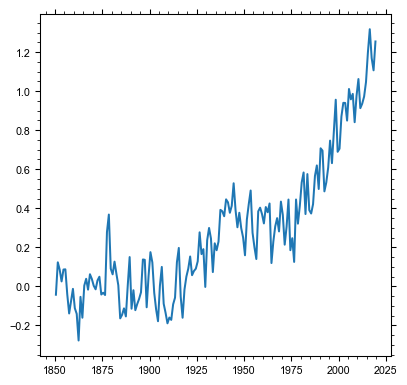

In [9]:
# GSAT/GMST ratio. Use CMIP5 ratio, calculated by me for Rogelj et al. 2019, method originally from Richardson et al. 2016
blratio = np.loadtxt('../data_input/cmip5_data_2019.txt')[5,:]
cowtan = cw_temp[:,1] - np.mean(cw_temp[:51,1])
years  = cw_temp[:,0]+0.5
blratio  = np.concatenate((np.ones(11), blratio))
Tobs = blratio * cowtan
pl.plot(years, Tobs)
#pl.plot(np.arange(1750,1901), best_land)
print(np.mean(Tobs[:51]))
print(np.mean(Tobs[160:170]))
#print(blratio)
len(Tobs)

## Simple experiment with ECS=3.7 and default Geoffroy params

In [10]:
def rmse(obs, mod):
    return np.sqrt(np.sum((obs-mod)**2)/len(obs))

In [11]:
models = ['CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','UKESM1-0-LL']

colors = {
    'ECLIPSE-constrained'  : '0.6',
    'CMIP6-constrained' : '0.3',
    'CanESM5'        : 'red',#'#1e4c24',
    'E3SM'           : 'darkorange',
    'GFDL-ESM4'      : 'yellowgreen', 
    'GFDL-CM4'       : 'yellow',#'green',
    'GISS-E2-1-G'    : 'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR'   : 'teal',
    'MIROC6'         : 'blue',#b85fb7',
    'MRI-ESM2-0'     : 'blueviolet',
    'NorESM2-LM'     : 'purple',#'red',
    'UKESM1-0-LL'    : 'crimson',
    'observations'   : 'black',
    'Oslo-CTM3'      : 'pink',
}

ls = {
    'CMIP6-constrained'  : '-',
    'ECLIPSE-constrained' : '-',
    'CanESM5'        : '-',
    'E3SM'           : '-',
    'GFDL-ESM4'      : '-',
    'GFDL-CM4'       : '-',
    'GISS-E2-1-G'    : '-',
    'HadGEM3-GC31-LL': '-',
    'IPSL-CM6A-LR'   : '-',
    'MIROC6'         : '-',
    'MRI-ESM2-0'     : '-',
    'NorESM2-LM'     : '-',
    'UKESM1-0-LL'    : '-',
    'Oslo-CTM3'      : '-',
    'observations'   : '-',
}

In [12]:
# load in Geoffroy two layer model parameters (pre-calculated by Glen Harris)
params = pd.read_fwf('../data_input/scmpy2L_calib_n=44_eps=fit_v20200702.txt', sep=' ')
params.set_index('Model', inplace=True)
cmip6_models = list(params.index)
params.rename(columns={"F4x":'q4x', "Lambda":'lamg', "Cmix":'cmix', "Cdeep":'cdeep', "Gamma":'gamma_2l', "Epsilon":'eff'}, inplace=True)

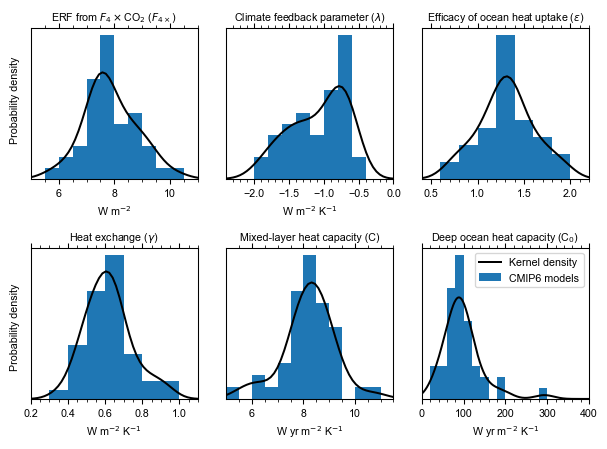

In [13]:
#cmip6_models = list(params['gamma_2l']['model_data']['EBM-epsilon'].keys())
fig, ax = pl.subplots(2,3, figsize=(16/2.54, 12/2.54))

ax[0,0].hist(params['q4x'], bins=np.arange(5,11,0.5), density=True)
f_q4x = st.gaussian_kde(params['q4x'], bw_method='silverman')
ax[0,0].plot(np.linspace(5,11), f_q4x(np.linspace(5,11)), color='k', label='Kernel density')
ax[0,0].set_yticks([])
ax[0,0].set_xlabel('W m$^{-2}$')
ax[0,0].set_title(r'ERF from $F_{4}\times$CO$_2$ ($F_{4\times}$)', fontsize=8)
ax[0,0].set_xlim(5,11)

ax[0,1].hist(-params['lamg'], bins=np.arange(-2,0.2,0.2), density=True)
f_lamg = st.gaussian_kde(-params['lamg'], bw_method='silverman')
ax[0,1].plot(np.linspace(-2.4,0), f_lamg(np.linspace(-2.4,0)), color='k', label='Kernel density')
ax[0,1].set_yticks([])
ax[0,1].set_xlabel('W m$^{-2}$ K$^{-1}$')
ax[0,1].set_title(r'Climate feedback parameter ($\lambda$)', fontsize=8)
ax[0,1].set_xlim(-2.4,0)

ax[0,2].hist(params['eff'], bins=np.arange(0.4,2.2,0.2), density=True)
f_eff = st.gaussian_kde(params['eff'], bw_method='silverman')
ax[0,2].plot(np.linspace(0.4,2.2), f_eff(np.linspace(0.4,2.2)), color='k', label='Kernel density')
ax[0,2].set_yticks([])
ax[0,2].set_title(r'Efficacy of ocean heat uptake ($\epsilon$)', fontsize=8)
ax[0,2].set_xlim(0.4,2.2)

ax[1,0].hist(params['gamma_2l'], bins=np.arange(0.3,1.3,0.1), density=True)
f_gamma_2l = st.gaussian_kde(params['gamma_2l'], bw_method='silverman')
ax[1,0].plot(np.linspace(0.2,1.1), f_gamma_2l(np.linspace(0.2,1.1)), color='k', label='Kernel density')
ax[1,0].set_yticks([])
ax[1,0].set_xlabel('W m$^{-2}$ K$^{-1}$')
ax[1,0].set_title(r'Heat exchange ($\gamma$)', fontsize=8)
ax[1,0].set_xlim(0.2,1.1)

ax[1,1].hist(params['cmix'], bins=np.arange(5,11.5,0.5), density=True)
f_cmix = st.gaussian_kde(params['cmix'], bw_method='silverman')
ax[1,1].plot(np.linspace(5,11.5), f_cmix(np.linspace(5,11.5)), color='k', label='Kernel density')
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('W yr m$^{-2}$ K$^{-1}$')
ax[1,1].set_title(r'Mixed-layer heat capacity (C)', fontsize=8)
ax[1,1].set_xlim(5,11.5)

ax[1,2].hist(params['cdeep'], bins=np.arange(0,420, 20), density=True, label='CMIP6 models')
f_cdeep = st.gaussian_kde(params['cdeep'], bw_method='silverman')
ax[1,2].plot(np.arange(0,400), f_cdeep(np.arange(0,400)), color='k', label='Kernel density')
ax[1,2].set_yticks([])
ax[1,2].set_xlabel('W yr m$^{-2}$ K$^{-1}$')
ax[1,2].set_title(r'Deep ocean heat capacity (C$_0$)', fontsize=8)
ax[1,2].set_xlim(0,400)
ax[1,2].legend()

pl.figtext(0.015,0.775,'Probability density', rotation=90, va='center', ha='center')
pl.figtext(0.015,0.275,'Probability density', rotation=90, va='center', ha='center')

fig.tight_layout(rect=[0.015,0,1,1])
pl.savefig('../figures/figureS4.png', dpi=300)
pl.savefig('../figures/figureS4.pdf')

In [14]:
# construct correlation matrix
pd.set_option('precision', 4)
params.corr()

,q4x,lamg,cmix,cdeep,gamma_2l,eff
q4x,1.0000,0.3835,-0.0207,0.1092,0.3590,0.4043
lamg,0.3835,1.0000,0.1949,0.3678,0.3631,-0.0887
cmix,-0.0207,0.1949,1.0000,0.0942,-0.1991,-0.0881
cdeep,0.1092,0.3678,0.0942,1.0000,0.3344,-0.3767
gamma_2l,0.3590,0.3631,-0.1991,0.3344,1.0000,0.1130
eff,0.4043,-0.0887,-0.0881,-0.3767,0.1130,1.0000


In [15]:
pd.set_option('precision', 2)
geoff_ecs_data = np.zeros(((len(cmip6_models))))
geoff_ecs_data = params['q4x'].values/params['lamg'].values/2
geoff_df_display = params.copy()
geoff_df_display['ECS'] = geoff_ecs_data
geoff_df_display.sort_index()

,q4x,lamg,cmix,cdeep,gamma_2l,eff,ECS
Model,,,,,,,
ACCESS-CM2,7.66,0.69,8.82,97.46,0.53,1.49,5.57
ACCESS-ESM1-5,6.97,0.72,9.02,96.79,0.61,1.71,4.83
AWI-CM-1-1-MR,8.41,1.30,8.17,54.70,0.49,1.30,3.24
BCC-CSM2-MR,6.89,1.06,8.51,73.69,0.64,1.32,3.25
BCC-ESM1,6.68,0.94,8.47,91.72,0.58,1.33,3.57
CAMS-CSM1-0,8.88,1.88,10.01,62.41,0.53,1.34,2.37
CAS-ESM2-0,7.13,0.93,7.57,72.83,0.45,1.43,3.84
CESM2,8.84,0.72,8.33,70.64,0.64,1.73,6.15
CESM2-FV2,7.94,0.56,7.96,91.10,0.70,1.91,7.10


In [16]:
samples = 100000

kde = st.gaussian_kde(params.T)
geoff_sample = kde.resample(size=int(samples*1.1), seed=3170812)
# remove unphysical combinations
geoff_sample[:,geoff_sample[0,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[1,:] <= 0.2] = np.nan
geoff_sample[:,geoff_sample[2,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[3,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[4,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[5,:] <= 0] = np.nan
#geoff_sample = geoff_sample[~np.isnan(geoff_sample)]
mask = np.all(np.isnan(geoff_sample), axis=0)
geoff_sample = geoff_sample[:,~mask]
geoff_sample_df=pd.DataFrame(
    data=geoff_sample[:,:samples].T, columns=['q4x','lamg','cmix','cdeep','gamma_2l','eff']
)
geoff_sample_df.to_csv('../data_output/geoff_sample.csv', index=False)
geoff_sample_df

,q4x,lamg,cmix,cdeep,gamma_2l,eff
0,8.57,0.95,7.62,99.24,0.52,1.28
1,7.89,0.83,8.15,82.94,0.44,0.95
2,6.34,1.45,7.71,28.00,0.57,1.36
3,8.55,1.01,8.35,95.45,0.76,1.48
4,8.02,1.03,7.73,106.04,0.98,1.43
...,...,...,...,...,...,...
99995,6.72,0.28,8.65,68.44,0.50,1.04
99996,6.03,0.23,8.67,48.01,0.51,1.68
99997,6.16,0.42,10.61,107.80,0.48,1.73
99998,10.63,2.11,6.42,139.54,0.94,1.85


In [17]:
# fractional uncertainties on ERF - based on the FAIR code
seed    = 36572 
zscore = st.norm.ppf(0.95)

# can only use published literature - so revert to FaIR and AR5 uncertainties. Use unmodified Etminan for methane, because RFMIP
# models central estimate is quite close.
unc_ranges = np.array([
    0.20,      # CO2
    0.28,      # CH4: updated value from etminan 2016
    0.20,      # N2O
    0.20,      # other WMGHGS
    0.50,      # tropospheric O3
    2.00,      # stratospheric O3
    1.00,      # stratospheric WV from CH4
    (98-57.4)/57.4,      # contrails
    0.00,      # black carbon on snow (lognormal)
    0.75,      # land use change
    0.50,      # volcanic
    0.50,      # solar (amplitude)
])/(zscore)

scale = st.norm.rvs(size=(samples,12), loc=np.ones((samples,12)), scale=np.ones((samples, 12)) * unc_ranges[None,:], random_state=seed)
scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)

# contrails slightly asymmetric
scale[scale[:,7]<1,7] = (57.4-19)/(98-57.4)*(scale[scale[:,7]<1,7]-1) + 1

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)
scale_df

,co2,ch4,n2o,other_wmghg,o3_tropospheric,o3_stratospheric,h2o_stratospheric,contrails,bc_on_snow,land_use,volcanic,solar
0,1.03,0.74,0.83,1.00,1.08,0.57,1.60,0.72,1.40,1.51,0.98,0.63
1,0.94,1.12,1.12,1.12,1.27,0.95,0.37,1.15,1.18,0.84,0.75,1.63
2,0.96,1.08,0.96,1.02,1.10,1.20,0.64,1.19,0.65,0.67,0.91,1.07
3,1.04,0.93,0.95,1.09,0.70,2.23,1.22,1.11,0.43,1.42,1.14,1.50
4,1.13,0.84,1.07,1.17,1.61,0.04,1.83,1.72,1.09,1.17,0.86,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.97,0.93,0.83,1.01,1.63,0.64,0.75,0.77,0.88,1.25,0.84,1.07
99996,0.82,1.21,1.06,1.09,0.76,1.03,0.45,1.31,0.89,0.59,1.13,1.03
99997,1.07,1.00,1.02,1.03,1.15,0.52,0.48,0.89,1.78,1.08,1.20,0.86
99998,1.16,0.92,1.13,1.06,0.65,0.80,-0.02,0.57,0.69,1.36,0.97,1.10


(array([5.0000e+00, 1.8400e+02, 2.5470e+03, 1.4563e+04, 3.4398e+04,
        3.1665e+04, 1.3704e+04, 2.6760e+03, 2.4900e+02, 9.0000e+00]),
 array([-0.98403304, -0.5837393 , -0.18344557,  0.21684817,  0.6171419 ,
         1.01743564,  1.41772938,  1.81802311,  2.21831685,  2.61861058,
         3.01890432]),
 <a list of 10 Patch objects>)

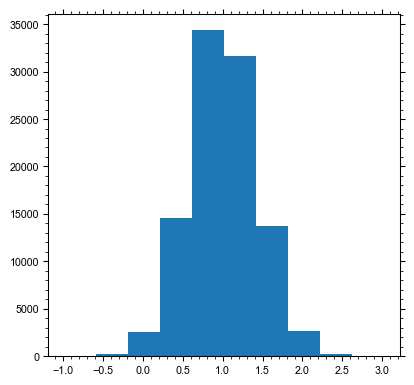

In [18]:
pl.hist(scale[:,7])

In [19]:
trend_solar = st.norm.rvs(size=samples, loc=0, scale=0.1/zscore, random_state=138294)

## Construct CMIP6 emissions-based forcing

In [20]:
# Grab CEDS emissions and unzip (RCMIP should already be here)
check_and_download('../data_input/CEDS_v_2020_09_11_emissions.zip', 'https://zenodo.org/record/4025316/files/CEDS_v_2020_09_11_emissions.zip')
with ZipFile('../data_input/CEDS_v_2020_09_11_emissions.zip', 'r') as zipObj:
    zipObj.extractall('../data_input/ceds')
os.remove('../data_input/CEDS_v_2020_09_11_emissions.zip')

In [21]:
emissions = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input/ceds/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.10,348.42,6.68,12.73,15.45,2.31,60.60
1751,2.07,343.82,6.62,12.59,15.19,2.28,59.67
1752,2.06,341.70,6.57,12.59,15.03,2.27,59.21
1753,2.07,343.57,6.64,12.53,15.18,2.28,59.61
1754,2.10,349.71,6.77,12.63,15.56,2.34,60.86
1755,2.10,348.04,6.70,12.76,15.36,2.32,60.41
1756,2.07,343.21,6.67,12.41,15.20,2.30,59.54
1757,2.15,355.83,6.80,13.13,15.70,2.38,61.86
1758,2.12,351.73,6.74,12.97,15.51,2.35,61.03


In [22]:
#emissions = pd.read_csv('../output_data/historical_slcf_emissions.csv', index_col='year')
emissions = emissions_ceds_update.drop(['CO','VOC','NOx','NH3'], axis=1)
emissions

,BC,OC,SO2
year,,,
1750,2.10,15.45,2.31
1751,2.07,15.19,2.28
1752,2.06,15.03,2.27
1753,2.07,15.18,2.28
1754,2.10,15.56,2.34
1755,2.10,15.36,2.32
1756,2.07,15.20,2.30
1757,2.15,15.70,2.38
1758,2.12,15.51,2.35


In [23]:
emissions_old_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
emissions_old = emissions_old_df.loc[(
        (emissions_old_df.Variable=='Emissions|BC')|
        (emissions_old_df.Variable=='Emissions|OC')|
        (emissions_old_df.Variable=='Emissions|Sulfur')
    ) & (emissions_old_df.Scenario=='ssp245') & (emissions_old_df.Region=='World'), '1750':'2020'].interpolate(axis=1).T
emissions_old.columns = ['BC','OC','SO2']

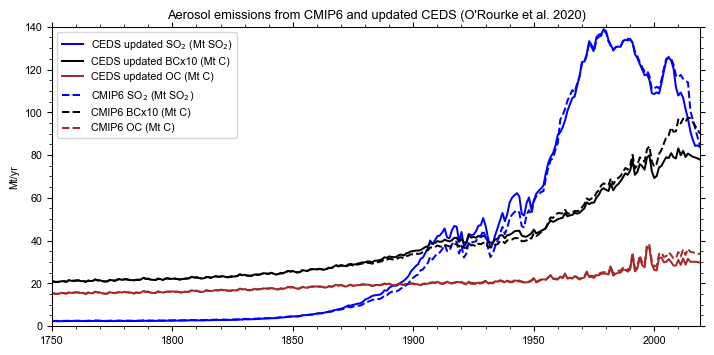

In [24]:
fig = pl.figure(figsize=(19/2.54, 9.5/2.54))
pl.plot(emissions.loc[1750:,'SO2'], label='CEDS updated SO$_2$ (Mt SO$_2$)', color='blue')
pl.plot(emissions.loc[1750:,'BC']*10, label='CEDS updated BCx10 (Mt C)', color='black')
pl.plot(emissions.loc[1750:,'OC'], label='CEDS updated OC (Mt C)', color='brown')
pl.plot(np.arange(1750,2020), emissions_old.loc['1750':'2019','SO2'].values, ls='--', color='blue', label='CMIP6 SO$_2$ (Mt SO$_2$)')
pl.plot(np.arange(1750,2020), emissions_old.loc['1750':'2019','BC'].values*10, ls='--', color='black', label='CMIP6 BCx10 (Mt C)')
pl.plot(np.arange(1750,2020), emissions_old.loc['1750':'2019','OC'].values, ls='--', color='brown', label='CMIP6 OC (Mt C)')
pl.xlim(1750,2019)
pl.ylim(0,140)
pl.legend()
pl.ylabel('Mt/yr')
pl.title("Aerosol emissions from CMIP6 and updated CEDS (O'Rourke et al. 2020)")
pl.tight_layout()
pl.savefig('../figures/figureS2.png', dpi=300)
pl.savefig('../figures/figureS2.pdf')

In [25]:
def aerocom(x, bc, oc, so2):
    return bc*x[0] + oc*x[1] + so2*x[2]

def ghan(x, beta, n0, n1):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

df = pd.read_csv('../data_output/ERFari_samples.csv')
ari_coeffs = df.values

df = pd.read_csv('../data_output/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

In [26]:
# Use Ringberg aerosol priors, from script provided to me
def uniform1684(a,b,seed,samples=2000):
    interval = (b-a)+((b-a)/(84-16)*32)
    lower = a-((b-a)/(84-16)*16)
    return st.uniform.rvs(lower, interval, size=samples, random_state=seed)

dtau    = uniform1684(0.02,0.04,123,samples=samples)
tau     = uniform1684(0.13,0.17,124,samples=samples)
S_tau   = uniform1684(-27,-20,125,samples=samples)
RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
dRatm_dtau = uniform1684(17,35,128,samples=samples)
c_tau    = uniform1684(0.59,0.71,129,samples=samples)
c_N      = uniform1684(0.19,0.29,130,samples=samples)
c_L      = uniform1684(0.21,0.29,131,samples=samples)
c_C      = uniform1684(0.59,1.07,132,samples=samples)
beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
beta_C_N   = uniform1684(0,0.1,135,samples=samples)
S_N = uniform1684(-27,-26,136,samples=samples)
S_L = uniform1684(-56,-54,137,samples=samples)
S_C = uniform1684(-153,-91,138,samples=samples)

rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
rfari_adj = dtau*dR_dRatm*dRatm_dtau

dlntau = dtau/tau
deltan = dlntau * beta_N_tau

rfaci = dlntau*beta_N_tau*S_N*c_N
erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

ERFari_scale = rfari + rfari_adj
ERFaci_scale = rfaci + erfaci_L + erfaci_C

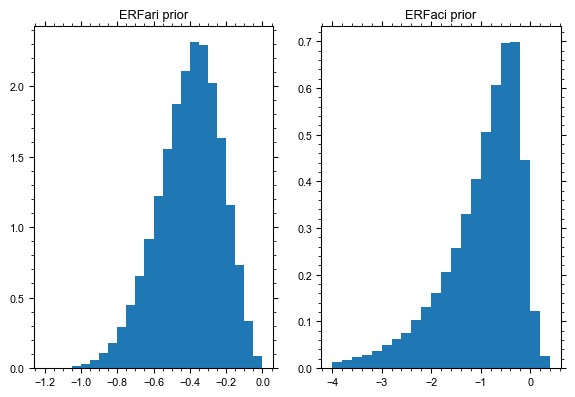

In [27]:
fig,ax = pl.subplots(1,2, figsize=(18/2.54,12/2.54))
ax[0].hist(ERFari_scale, bins=np.arange(-1.2,0.05,0.05), density=True);
ax[0].set_title('ERFari prior');
ax[1].hist(ERFaci_scale, bins=np.arange(-4,0.5,0.2), density=True);
ax[1].set_title('ERFaci prior');

In [28]:
# Define our dicts
ERFari = {}
ERFaci = {}
temp = {}
ks = {}
ohc = {}
hflux = {}

ks['temp'] = {}
ks['ohc'] = {}
ks['multi'] = {}

In [29]:
# # load dicts
# ERFari = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/ERFari.h5')
# ERFaci = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/ERFaci.h5')
# temp   = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/temp.h5')
# ks     = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/knutti_score.h5')
# ohc    = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/ohc.h5')
# hflux  = load_dict_from_hdf5('/nfs/a65/pmcjs/AR6_tuning/aerosols/hflux.h5')

In [30]:
intvar = np.loadtxt('../data_output/piControl/internal_variability_piControl.txt')

In [31]:
def knutti_score(obs, mod, sigma_D=None):
    """
    obs: observations data: array of size (nyears,)
    mod: model data: array of size (nyears, nsamples)
    """
    samples = mod.shape[1]
    rm_d = np.ones(samples) * np.nan
    for i in range(samples):
        rm_d[i] = rmse(obs, mod[:, i])
    if sigma_D==None:
        sigma_D = np.nanmin(rm_d)
    veracity = np.exp(-rm_d**2/sigma_D**2) 
    ks_raw = veracity
    ks_raw[np.isnan(ks_raw)] = 0
    ks = ks_raw/np.sum(ks_raw)
    return ks

In [32]:
def weighted_percentile(a, w, q):
    if isinstance(q, (list, tuple, np.ndarray)):
        result = []
        for iq in q:
            result.append(wquantiles.quantile(a, w, iq))
    else:
        result = wquantiles.quantile(a, w, q)
    return result

In [33]:
def simple_weight(obs, mod, sigma_D):
    veracity = np.exp(-(mod-obs)**2/sigma_D**2)
    similarity = 1 # I see no good reason to change this #
    ks_raw = veracity/similarity
    ks_raw[np.isnan(ks_raw)] = 0
    ks = ks_raw/np.sum(ks_raw)
    return ks

## CEDS emissions

In [34]:
ERFari['CMIP6-constrained'] = np.zeros((270,samples))
for i in tqdm_notebook(range(samples)):
    ts2010 = np.mean(aerocom([emissions.loc[2005:2015,'BC'], emissions.loc[2005:2015,'OC'], emissions.loc[2005:2015,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0]))
    ts1850 = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
    ts1750 = aerocom([emissions.loc[1750,'BC'], emissions.loc[1750,'OC'], emissions.loc[1750,'SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
    ERFari['CMIP6-constrained'][:,i] = (
        aerocom([emissions['BC'], emissions['OC'], emissions['SO2']], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0])
        - ts1750
    )/(ts2010-ts1850)*(ERFari_scale[i])

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100000 [00:00<?, ?it/s]

In [35]:
ERFaci['CMIP6-constrained'] = np.zeros((270,samples))
for i in tqdm_notebook(range(samples)):
    ts2010 = np.mean(ghan([emissions.loc[2005:2015,'SO2'], emissions.loc[2005:2015,'BC']+emissions.loc[2005:2015,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]))
    ts1850 = ghan([emissions.loc[1850,'SO2'],emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
    ts1750 = ghan([emissions.loc[1750,'SO2'],emissions.loc[1750,'BC']+emissions.loc[1750,'OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
    ERFaci['CMIP6-constrained'][:,i] = (
        ghan([emissions['SO2'],emissions['BC']+emissions['OC']], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) 
        - ts1750
    )/(ts2010-ts1850)*(ERFaci_scale[i])

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100000 [00:00<?, ?it/s]

In [36]:
set1 = np.squeeze(np.where(np.logical_and(
    1.001*(np.percentile((ERFari['CMIP6-constrained'][-1,:] + ERFaci['CMIP6-constrained'][-1,:]), 50))
    < (ERFari['CMIP6-constrained'][-1,:]+ERFaci['CMIP6-constrained'][-1,:]), (ERFari['CMIP6-constrained'][-1,:]+ERFaci['CMIP6-constrained'][-1,:]) < 
    0.999*(np.percentile((ERFari['CMIP6-constrained'][-1,:] + ERFaci['CMIP6-constrained'][-1,:]), 50)))))
set1

array([ 2393,  2723,  3162,  3358,  4245,  5680,  6592,  7046,  7938,
        8796,  9952, 11529, 11562, 14743, 15099, 15723, 16220, 17206,
       18010, 18881, 19272, 19565, 23988, 24227, 24646, 25377, 30021,
       31357, 31466, 31779, 31854, 32377, 33141, 35090, 37072, 38237,
       39293, 42308, 42691, 43908, 44553, 47559, 48350, 49086, 50067,
       50617, 52700, 52982, 54383, 55352, 56789, 57002, 57169, 57350,
       58198, 59194, 60436, 61196, 61925, 62134, 62497, 63931, 63992,
       64982, 65318, 66119, 66240, 66327, 67561, 68151, 68446, 68615,
       69180, 69595, 69909, 70929, 71128, 72344, 73386, 76722, 77311,
       77363, 77375, 77762, 77844, 78209, 79242, 79470, 79803, 81713,
       83919, 84152, 84603, 86847, 87091, 88352, 88856, 88906, 89803,
       90231, 91460, 91902, 91966, 92266, 92546, 92622, 93429, 94393,
       94565, 94955, 95998, 96497, 96840, 96910, 97469, 99097])

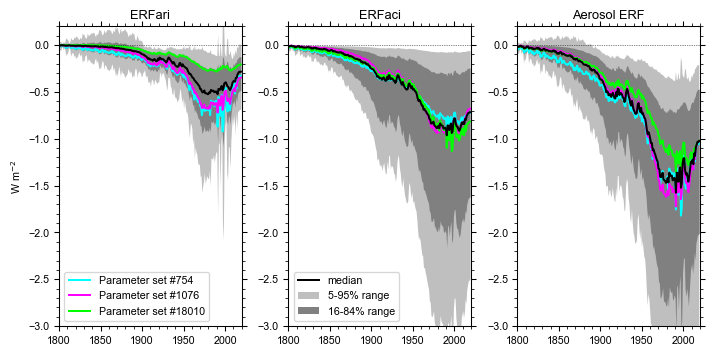

In [37]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54, 9.5/2.54))
ax[0].fill_between(np.arange(1750,2020), np.percentile(ERFari['CMIP6-constrained'], 5, axis=1), np.percentile(ERFari['CMIP6-constrained'], 95, axis=1), color='0.75', lw=0);
ax[0].fill_between(np.arange(1750,2020), np.percentile(ERFari['CMIP6-constrained'], 16, axis=1), np.percentile(ERFari['CMIP6-constrained'], 84, axis=1), color='0.5', lw=0);
ax[0].plot(np.arange(1750,2020), np.percentile(ERFari['CMIP6-constrained'], 50, axis=1), color='k', zorder=10)
ax[0].plot(np.arange(1750,2020), ERFari['CMIP6-constrained'][:,754], color='cyan', label='Parameter set #754')
ax[0].plot(np.arange(1750,2020), ERFari['CMIP6-constrained'][:,1076], color='magenta', label='Parameter set #1076')
ax[0].plot(np.arange(1750,2020), ERFari['CMIP6-constrained'][:,18010], color='lime', label='Parameter set #18010')
ax[0].legend()
ax[0].set_xlim(1800,2020)
ax[0].set_title('ERFari')
ax[0].set_ylabel('W m$^{-2}$')

ax[1].fill_between(np.arange(1750,2020), np.percentile(ERFaci['CMIP6-constrained'], 5, axis=1), np.percentile(ERFaci['CMIP6-constrained'], 95, axis=1), color='0.75', lw=0, label='5-95% range');
ax[1].fill_between(np.arange(1750,2020), np.percentile(ERFaci['CMIP6-constrained'], 16, axis=1), np.percentile(ERFaci['CMIP6-constrained'], 84, axis=1), color='0.5', lw=0, label='16-84% range');
ax[1].plot(np.arange(1750,2020), np.percentile(ERFaci['CMIP6-constrained'], 50, axis=1), color='k', label='median', zorder=10)
ax[1].plot(np.arange(1750,2020), ERFaci['CMIP6-constrained'][:,754], color='cyan')
ax[1].plot(np.arange(1750,2020), ERFaci['CMIP6-constrained'][:,1076], color='magenta')
ax[1].plot(np.arange(1750,2020), ERFaci['CMIP6-constrained'][:,18010], color='lime')
ax[1].legend()
ax[1].set_xlim(1800,2020)
ax[1].set_title('ERFaci')

ax[2].fill_between(np.arange(1750,2020), np.percentile(ERFari['CMIP6-constrained']+ERFaci['CMIP6-constrained'], 5, axis=1), np.percentile(ERFari['CMIP6-constrained']+ERFaci['CMIP6-constrained'], 95, axis=1), color='0.75', lw=0);
ax[2].fill_between(np.arange(1750,2020), np.percentile(ERFari['CMIP6-constrained']+ERFaci['CMIP6-constrained'], 16, axis=1), np.percentile(ERFari['CMIP6-constrained']+ERFaci['CMIP6-constrained'], 84, axis=1), color='0.5', lw=0);
ax[2].plot(np.arange(1750,2020), np.percentile(ERFari['CMIP6-constrained']+ERFaci['CMIP6-constrained'], 50, axis=1), color='k', zorder=10)
ax[2].plot(np.arange(1750,2020), ERFari['CMIP6-constrained'][:,754]+ERFaci['CMIP6-constrained'][:,754], color='cyan', label='Ensemble 754')
ax[2].plot(np.arange(1750,2020), ERFari['CMIP6-constrained'][:,1076]+ERFaci['CMIP6-constrained'][:,1076], color='magenta', label='Ensemble 1076')
ax[2].plot(np.arange(1750,2020), ERFari['CMIP6-constrained'][:,18010]+ERFaci['CMIP6-constrained'][:,18010], color='lime', label='Ensemble 18010')
ax[2].set_xlim(1800,2020)
ax[2].set_title('Aerosol ERF')

ax[0].set_ylim(-3,0.2)
ax[1].set_ylim(-3,0.2)
ax[2].set_ylim(-3,0.2)
ax[0].axhline(0, ls=':', lw=0.5, color='k')
ax[1].axhline(0, ls=':', lw=0.5, color='k')
ax[2].axhline(0, ls=':', lw=0.5, color='k')

fig.tight_layout()
pl.savefig('../figures/figure5.png', dpi=300)
pl.savefig('../figures/figure5.pdf')

In [38]:
in_forcing = baseline_forcing.copy()
in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
in_forcing = in_forcing * scale_df.loc[0,:]
in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[0], 270)
in_forcing['aerosol-radiation_interactions'] = ERFari['CMIP6-constrained'][:270,0]
in_forcing['aerosol-cloud_interactions'] = ERFaci['CMIP6-constrained'][:270,0]
in_forcing['total'] = in_forcing.sum(axis=1)
in_forcing['total']

year
1750    2.48e-01
1751    2.56e-01
1752    2.51e-01
1753    2.17e-01
1754    1.69e-01
1755    1.46e-01
1756   -9.46e-02
1757    2.88e-02
1758    1.59e-01
1759    2.16e-01
1760    2.23e-01
1761    2.36e-01
1762   -7.50e-01
1763   -4.64e-01
1764   -6.65e-03
1765    8.42e-02
1766   -2.11e-01
1767   -2.61e-01
1768    1.20e-02
1769    1.87e-01
1770    1.03e-01
1771    1.89e-01
1772    2.60e-01
1773    2.58e-01
1774    1.94e-01
1775    2.01e-01
1776    2.04e-01
1777    1.92e-01
1778    2.07e-01
1779    2.71e-01
1780    2.71e-01
1781    2.91e-01
1782    2.81e-01
1783   -1.68e+00
1784   -3.72e+00
1785   -1.43e+00
1786   -5.08e-01
1787   -8.88e-02
1788    1.14e-01
1789    2.58e-01
1790    2.97e-01
1791    3.29e-01
1792    3.35e-01
1793    3.14e-01
1794    2.44e-01
1795    2.45e-01
1796    9.78e-02
1797   -4.07e-02
1798    4.87e-02
1799    1.45e-01
1800    1.74e-01
1801    2.22e-01
1802    2.40e-01
1803    2.71e-01
1804    2.91e-01
1805    2.54e-01
1806    2.61e-01
1807    2.39e-01
1808    1

In [39]:
temp['CMIP6-constrained'] = np.zeros((270, samples))
ohc['CMIP6-constrained'] = np.zeros((270, samples))
hflux['CMIP6-constrained'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['CMIP6-constrained'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['CMIP6-constrained'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['CMIP6-constrained'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['CMIP6-constrained'][:,i] = out.ohc
    hflux['CMIP6-constrained'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

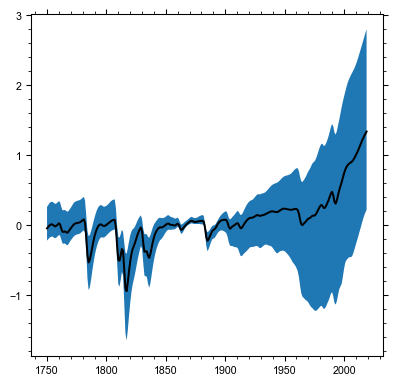

In [40]:
pl.fill_between(np.arange(1750,2020), np.percentile(temp['CMIP6-constrained'], 5, axis=1), np.percentile(temp['CMIP6-constrained'], 95, axis=1))
pl.plot(np.arange(1750,2020), np.median(temp['CMIP6-constrained'], axis=1), color='k')

In [41]:
ks['temp']['CMIP6-constrained'] = knutti_score(Tobs, temp['CMIP6-constrained'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['CMIP6-constrained'] = simple_weight(358, 10*(ohc['CMIP6-constrained'][268,:]-ohc['CMIP6-constrained'][221,:]), sigma_D=37)
ks['multi']['CMIP6-constrained'] = (ks['temp']['CMIP6-constrained']*ks['ohc']['CMIP6-constrained'])/(np.sum(ks['temp']['CMIP6-constrained']*ks['ohc']['CMIP6-constrained']))

In [42]:
print(weighted_percentile(ERFari['CMIP6-constrained'][269,:]+ERFaci['CMIP6-constrained'][269,:], ks['temp']['CMIP6-constrained'][:], [.05,.16,.5,.84,.95]))
print(weighted_percentile(ERFari['CMIP6-constrained'][269,:]+ERFaci['CMIP6-constrained'][269,:], ks['ohc']['CMIP6-constrained'][:], [.05,.16,.5,.84,.95]))
print(weighted_percentile(ERFari['CMIP6-constrained'][269,:]+ERFaci['CMIP6-constrained'][269,:], ks['multi']['CMIP6-constrained'][:], [.05,.16,.5,.84,.95]))

[-1.4256959927421602, -1.1407921600994297, -0.7665174976354688, -0.4523775310234071, -0.27589739339311026]
[-1.829055433936443, -1.5313809335521056, -1.0948681917443621, -0.6617896772115405, -0.38959480213080566]
[-1.5458678687471548, -1.2633682722784245, -0.8690609828424641, -0.5428478022838173, -0.3528943234993417]


## Oslo-CTM3

In [43]:
Lund2010ari = Lund_ERFari[255:265].mean()
Lund2010aci = Lund_ERFaci[255:265].mean()
Lund1850ari = Lund_ERFari[100]
Lund1850aci = Lund_ERFaci[100]
ERFari['Oslo-CTM3'] = np.zeros((270,samples))
ERFaci['Oslo-CTM3'] = np.zeros((270,samples))
for i in range(samples):
    ERFaci['Oslo-CTM3'][:,i] = Lund_ERFaci[:270]/(Lund2010aci-Lund1850aci)*(ERFaci_scale[i])
    ERFari['Oslo-CTM3'][:,i] = Lund_ERFari[:270]/(Lund2010ari-Lund1850aci)*(ERFari_scale[i])

In [44]:
temp['Oslo-CTM3'] = np.zeros((270, samples))
ohc['Oslo-CTM3'] = np.zeros((270, samples))
hflux['Oslo-CTM3'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['Oslo-CTM3'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['Oslo-CTM3'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['Oslo-CTM3'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['Oslo-CTM3'][:,i] = out.ohc
    hflux['Oslo-CTM3'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [45]:
ks['temp']['Oslo-CTM3'] = knutti_score(Tobs, temp['Oslo-CTM3'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['Oslo-CTM3'] = simple_weight(358, 10*(ohc['Oslo-CTM3'][268,:]-ohc['Oslo-CTM3'][221,:]), sigma_D=37)
ks['multi']['Oslo-CTM3'] = (ks['temp']['Oslo-CTM3']*ks['ohc']['Oslo-CTM3'])/(np.sum(ks['temp']['Oslo-CTM3']*ks['ohc']['Oslo-CTM3']))

In [47]:
with open("../data_output/cmip6_aerosol_coefficients.json", "r") as read_file:
    aero_coeffs = json.load(read_file)

aero_coeffs

{'CanESM5': {'ERFari': {'BC': 0.03259345198118766,
   'OC': -0.00034665609336649486,
   'SO2': -0.002487615983404445},
  'ERFaci': {'beta': 0.7274280721426704,
   'n0': 58.948258333062675,
   'n1': 24.61657702556549}},
 'E3SM': {'ERFari': {'BC': 0.024823190009656656,
   'OC': -0.012632191220637126,
   'SO2': -0.0009420909944919762},
  'ERFaci': {'beta': 2.0481991634358407,
   'n0': 155.89799978930552,
   'n1': 71.34330585125267}},
 'GFDL-CM4': {'ERFari': {'BC': 0.026856014968248784,
   'OC': -0.0020895008185214353,
   'SO2': -0.002605796763298011},
  'ERFaci': {'beta': 3.501486804413858,
   'n0': 692.7367590913047,
   'n1': 382.89732191508506}},
 'GFDL-ESM4': {'ERFari': {'BC': 0.10170074516511608,
   'OC': -0.030419203142294612,
   'SO2': -0.0026386847098018047},
  'ERFaci': {'beta': 3096.16251581202,
   'n0': 913507.2895844509,
   'n1': 202621.90038761534}},
 'GISS-E2-1-G': {'ERFari': {'BC': 0.1461322138696791,
   'OC': -0.044148599787293644,
   'SO2': -0.006678277853015948},
  'ERFac

## GFDL-ESM4

In [48]:
GFDLESM2010ari = GFDLESM_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+GFDLESM_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
GFDLESM2010aci = GFDLESM_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+GFDLESM_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['GFDL-ESM4'] = np.zeros((270,samples))
ERFaci['GFDL-ESM4'] = np.zeros((270,samples))
GFDLESMari = np.zeros(270)
GFDLESMaci = np.zeros(270)
GFDLESMari[100:265] = GFDLESM_aerforcing.loc[0:165, 'aprp_ERFariSW'].values+GFDLESM_aerforcing.loc[0:165, 'aprp_ERFariLW'].values
GFDLESMaci[100:265] = GFDLESM_aerforcing.loc[0:165, 'aprp_ERFaciSW'].values+GFDLESM_aerforcing.loc[0:165, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['GFDL-ESM4']['ERFari']['BC'], aero_coeffs['GFDL-ESM4']['ERFari']['OC'], aero_coeffs['GFDL-ESM4']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['GFDL-ESM4']['ERFaci']['beta'], aero_coeffs['GFDL-ESM4']['ERFaci']['n0'], aero_coeffs['GFDL-ESM4']['ERFaci']['n1'])
GFDLESMari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['GFDL-ESM4']['ERFari']['BC'], aero_coeffs['GFDL-ESM4']['ERFari']['OC'], aero_coeffs['GFDL-ESM4']['ERFari']['SO2']) - ts1850ari
GFDLESMaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['GFDL-ESM4']['ERFaci']['beta'], aero_coeffs['GFDL-ESM4']['ERFaci']['n0'], aero_coeffs['GFDL-ESM4']['ERFaci']['n1']) - ts1850aci
GFDLESMari[265:] = aerocom([emissions.loc[2015:2019,'BC'], emissions.loc[2015:2019,'OC'], emissions.loc[2015:2019,'SO2']], aero_coeffs['GFDL-ESM4']['ERFari']['BC'], aero_coeffs['GFDL-ESM4']['ERFari']['OC'], aero_coeffs['GFDL-ESM4']['ERFari']['SO2']) - ts1850ari
GFDLESMaci[265:] = ghan([emissions.loc[2015:2019,'SO2'], emissions.loc[2015:2019,'BC']+emissions.loc[2015:2019,'OC']], aero_coeffs['GFDL-ESM4']['ERFaci']['beta'], aero_coeffs['GFDL-ESM4']['ERFaci']['n0'], aero_coeffs['GFDL-ESM4']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['GFDL-ESM4'][:,i] = (GFDLESMaci-GFDLESMaci[0])/GFDLESM2010aci*(ERFaci_scale[i])
    ERFari['GFDL-ESM4'][:,i] = (GFDLESMari-GFDLESMari[0])/GFDLESM2010ari*(ERFari_scale[i])

In [49]:
temp['GFDL-ESM4'] = np.zeros((270, samples))
ohc['GFDL-ESM4'] = np.zeros((270, samples))
hflux['GFDL-ESM4'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['GFDL-ESM4'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['GFDL-ESM4'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['GFDL-ESM4'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['GFDL-ESM4'][:,i] = out.ohc
    hflux['GFDL-ESM4'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [50]:
ks['temp']['GFDL-ESM4'] = knutti_score(Tobs, temp['GFDL-ESM4'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['GFDL-ESM4'] = simple_weight(358, 10*(ohc['GFDL-ESM4'][268,:]-ohc['GFDL-ESM4'][221,:]), sigma_D=37)
ks['multi']['GFDL-ESM4'] = (ks['temp']['GFDL-ESM4']*ks['ohc']['GFDL-ESM4'])/(np.sum(ks['temp']['GFDL-ESM4']*ks['ohc']['GFDL-ESM4']))

## UKESM1-0-LL

In [51]:
UKESM2010ari = UKESM_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+UKESM_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
UKESM2010aci = UKESM_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+UKESM_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['UKESM1-0-LL'] = np.zeros((270,samples))
ERFaci['UKESM1-0-LL'] = np.zeros((270,samples))
UKESMari = np.zeros(270)
UKESMaci = np.zeros(270)
UKESMari[100:265] = UKESM_aerforcing.loc[0:165, 'aprp_ERFariSW'].values+UKESM_aerforcing.loc[0:165, 'aprp_ERFariLW'].values
UKESMaci[100:265] = UKESM_aerforcing.loc[0:165, 'aprp_ERFaciSW'].values+UKESM_aerforcing.loc[0:165, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['UKESM1-0-LL']['ERFari']['BC'], aero_coeffs['UKESM1-0-LL']['ERFari']['OC'], aero_coeffs['UKESM1-0-LL']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['UKESM1-0-LL']['ERFaci']['beta'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n0'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n1'])
UKESMari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['UKESM1-0-LL']['ERFari']['BC'], aero_coeffs['UKESM1-0-LL']['ERFari']['OC'], aero_coeffs['UKESM1-0-LL']['ERFari']['SO2']) - ts1850ari
UKESMaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['UKESM1-0-LL']['ERFaci']['beta'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n0'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n1']) - ts1850aci
UKESMari[265:] = aerocom([emissions.loc[2015:2019,'BC'], emissions.loc[2015:2019,'OC'], emissions.loc[2015:2019,'SO2']], aero_coeffs['UKESM1-0-LL']['ERFari']['BC'], aero_coeffs['UKESM1-0-LL']['ERFari']['OC'], aero_coeffs['UKESM1-0-LL']['ERFari']['SO2']) - ts1850ari
UKESMaci[265:] = ghan([emissions.loc[2015:2019,'SO2'], emissions.loc[2015:2019,'BC']+emissions.loc[2015:2019,'OC']], aero_coeffs['UKESM1-0-LL']['ERFaci']['beta'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n0'], aero_coeffs['UKESM1-0-LL']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['UKESM1-0-LL'][:,i] = (UKESMaci-UKESMaci[0])/UKESM2010aci*(ERFaci_scale[i])
    ERFari['UKESM1-0-LL'][:,i] = (UKESMari-UKESMari[0])/UKESM2010ari*(ERFari_scale[i])

In [52]:
temp['UKESM1-0-LL'] = np.zeros((270, samples))
ohc['UKESM1-0-LL'] = np.zeros((270, samples))
hflux['UKESM1-0-LL'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['UKESM1-0-LL'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['UKESM1-0-LL'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['UKESM1-0-LL'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['UKESM1-0-LL'][:,i] = out.ohc
    hflux['UKESM1-0-LL'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [53]:
ks['temp']['UKESM1-0-LL'] = knutti_score(Tobs, temp['UKESM1-0-LL'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['UKESM1-0-LL'] = simple_weight(358, 10*(ohc['UKESM1-0-LL'][268,:]-ohc['UKESM1-0-LL'][221,:]), sigma_D=37)
ks['multi']['UKESM1-0-LL'] = (ks['temp']['UKESM1-0-LL']*ks['ohc']['UKESM1-0-LL'])/(np.sum(ks['temp']['UKESM1-0-LL']*ks['ohc']['UKESM1-0-LL']))

## CanESM5

In [54]:
CanESM2010ari = CanESM5_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+CanESM5_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
CanESM2010aci = CanESM5_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+CanESM5_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['CanESM5'] = np.zeros((270,samples))
ERFaci['CanESM5'] = np.zeros((270,samples))
CanESMari = np.zeros(270)
CanESMaci = np.zeros(270)
CanESMari[100:] = CanESM5_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+CanESM5_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
CanESMaci[100:] = CanESM5_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+CanESM5_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['CanESM5']['ERFari']['BC'], aero_coeffs['CanESM5']['ERFari']['OC'], aero_coeffs['CanESM5']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['CanESM5']['ERFaci']['beta'], aero_coeffs['CanESM5']['ERFaci']['n0'], aero_coeffs['CanESM5']['ERFaci']['n1'])
CanESMari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['CanESM5']['ERFari']['BC'], aero_coeffs['CanESM5']['ERFari']['OC'], aero_coeffs['CanESM5']['ERFari']['SO2']) - ts1850ari
CanESMaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['CanESM5']['ERFaci']['beta'], aero_coeffs['CanESM5']['ERFaci']['n0'], aero_coeffs['CanESM5']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['CanESM5'][:,i] = (CanESMaci-CanESMaci[0])/CanESM2010aci*(ERFaci_scale[i])
    ERFari['CanESM5'][:,i] = (CanESMari-CanESMari[0])/CanESM2010ari*(ERFari_scale[i])

In [55]:
temp['CanESM5'] = np.zeros((270, samples))
ohc['CanESM5'] = np.zeros((270, samples))
hflux['CanESM5'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['CanESM5'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['CanESM5'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['CanESM5'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['CanESM5'][:,i] = out.ohc
    hflux['CanESM5'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [56]:
ks['temp']['CanESM5'] = knutti_score(Tobs, temp['CanESM5'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['CanESM5'] = simple_weight(358, 10*(ohc['CanESM5'][268,:]-ohc['CanESM5'][221,:]), sigma_D=37)
ks['multi']['CanESM5'] = (ks['temp']['CanESM5']*ks['ohc']['CanESM5'])/(np.sum(ks['temp']['CanESM5']*ks['ohc']['CanESM5']))

## E3SM

In [57]:
# take 05-14 mean for E3SM
E3SM2010ari = E3SM_aerforcing.loc[135:144,'aprp_ERFariSW'].mean()+E3SM_aerforcing.loc[135:144,'aprp_ERFariLW'].mean()
E3SM2010aci = E3SM_aerforcing.loc[135:144,'aprp_ERFaciSW'].mean()+E3SM_aerforcing.loc[135:144,'aprp_ERFaciLW'].mean()
ERFari['E3SM'] = np.zeros((270,samples))
ERFaci['E3SM'] = np.zeros((270,samples))
E3SMari = np.zeros(270)
E3SMaci = np.zeros(270)
E3SMari[120:265] = E3SM_aerforcing.loc[0:145, 'aprp_ERFariSW'].values+E3SM_aerforcing.loc[0:145, 'aprp_ERFariLW'].values
E3SMaci[120:265] = E3SM_aerforcing.loc[0:145, 'aprp_ERFaciSW'].values+E3SM_aerforcing.loc[0:145, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['E3SM']['ERFari']['BC'], aero_coeffs['E3SM']['ERFari']['OC'], aero_coeffs['E3SM']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['E3SM']['ERFaci']['beta'], aero_coeffs['E3SM']['ERFaci']['n0'], aero_coeffs['E3SM']['ERFaci']['n1'])
E3SMari[:120] = aerocom([emissions.loc[1750:1869,'BC'], emissions.loc[1750:1869,'OC'], emissions.loc[1750:1869,'SO2']], aero_coeffs['E3SM']['ERFari']['BC'], aero_coeffs['E3SM']['ERFari']['OC'], aero_coeffs['E3SM']['ERFari']['SO2']) - ts1850ari
E3SMaci[:120] = ghan([emissions.loc[1750:1869,'SO2'], emissions.loc[1750:1869,'BC']+emissions.loc[1750:1869,'OC']], aero_coeffs['E3SM']['ERFaci']['beta'], aero_coeffs['E3SM']['ERFaci']['n0'], aero_coeffs['E3SM']['ERFaci']['n1']) - ts1850aci
E3SMari[265:] = aerocom([emissions.loc[2015:2019,'BC'], emissions.loc[2015:2019,'OC'], emissions.loc[2015:2019,'SO2']], aero_coeffs['E3SM']['ERFari']['BC'], aero_coeffs['E3SM']['ERFari']['OC'], aero_coeffs['E3SM']['ERFari']['SO2']) - ts1850ari
E3SMaci[265:] = ghan([emissions.loc[2015:2019,'SO2'], emissions.loc[2015:2019,'BC']+emissions.loc[2015:2019,'OC']], aero_coeffs['E3SM']['ERFaci']['beta'], aero_coeffs['E3SM']['ERFaci']['n0'], aero_coeffs['E3SM']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['E3SM'][:,i] = (E3SMaci-E3SMaci[0])/E3SM2010aci*(ERFaci_scale[i])
    ERFari['E3SM'][:,i] = (E3SMari-E3SMari[0])/E3SM2010ari*(ERFari_scale[i])

In [58]:
temp['E3SM'] = np.zeros((270, samples))
ohc['E3SM'] = np.zeros((270, samples))
hflux['E3SM'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['E3SM'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['E3SM'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=0.2
    )
    out = scm.run()
    temp['E3SM'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['E3SM'][:,i] = out.ohc
    hflux['E3SM'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [59]:
ks['temp']['E3SM'] = knutti_score(Tobs, temp['E3SM'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['E3SM'] = simple_weight(358, 10*(ohc['E3SM'][268,:]-ohc['E3SM'][221,:]), sigma_D=37)
ks['multi']['E3SM'] = (ks['temp']['E3SM']*ks['ohc']['E3SM'])/(np.sum(ks['temp']['E3SM']*ks['ohc']['E3SM']))

## GFDL-CM4

In [60]:
GFDL2010ari = GFDL_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+GFDL_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
GFDL2010aci = GFDL_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+GFDL_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['GFDL-CM4'] = np.zeros((270,samples))
ERFaci['GFDL-CM4'] = np.zeros((270,samples))
GFDLari = np.zeros(270)
GFDLaci = np.zeros(270)
GFDLari[100:] = GFDL_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+GFDL_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
GFDLaci[100:] = GFDL_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+GFDL_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['GFDL-CM4']['ERFari']['BC'], aero_coeffs['GFDL-CM4']['ERFari']['OC'], aero_coeffs['GFDL-CM4']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['GFDL-CM4']['ERFaci']['beta'], aero_coeffs['GFDL-CM4']['ERFaci']['n0'], aero_coeffs['GFDL-CM4']['ERFaci']['n1'])
GFDLari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['GFDL-CM4']['ERFari']['BC'], aero_coeffs['GFDL-CM4']['ERFari']['OC'], aero_coeffs['GFDL-CM4']['ERFari']['SO2']) - ts1850ari
GFDLaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['GFDL-CM4']['ERFaci']['beta'], aero_coeffs['GFDL-CM4']['ERFaci']['n0'], aero_coeffs['GFDL-CM4']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['GFDL-CM4'][:,i] = (GFDLaci-GFDLaci[0])/GFDL2010aci*(ERFaci_scale[i])
    ERFari['GFDL-CM4'][:,i] = (GFDLari-GFDLari[0])/GFDL2010ari*(ERFari_scale[i])

In [61]:
temp['GFDL-CM4'] = np.zeros((270, samples))
ohc['GFDL-CM4'] = np.zeros((270, samples))
hflux['GFDL-CM4'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['GFDL-CM4'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['GFDL-CM4'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['GFDL-CM4'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['GFDL-CM4'][:,i] = out.ohc
    hflux['GFDL-CM4'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [62]:
ks['temp']['GFDL-CM4'] = knutti_score(Tobs, temp['GFDL-CM4'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['GFDL-CM4'] = simple_weight(358, 10*(ohc['GFDL-CM4'][268,:]-ohc['GFDL-CM4'][221,:]), sigma_D=37)
ks['multi']['GFDL-CM4'] = (ks['temp']['GFDL-CM4']*ks['ohc']['GFDL-CM4'])/(np.sum(ks['temp']['GFDL-CM4']*ks['ohc']['GFDL-CM4']))

## GISS-E2-1-G

In [63]:
GISS2010ari = GISS_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+GISS_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
GISS2010aci = GISS_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+GISS_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['GISS-E2-1-G'] = np.zeros((270,samples))
ERFaci['GISS-E2-1-G'] = np.zeros((270,samples))
GISSari = np.zeros(270)
GISSaci = np.zeros(270)
GISSari[100:] = GISS_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+GISS_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
GISSaci[100:] = GISS_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+GISS_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['GISS-E2-1-G']['ERFari']['BC'], aero_coeffs['GISS-E2-1-G']['ERFari']['OC'], aero_coeffs['GISS-E2-1-G']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['GISS-E2-1-G']['ERFaci']['beta'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n0'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n1'])
GISSari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['GISS-E2-1-G']['ERFari']['BC'], aero_coeffs['GISS-E2-1-G']['ERFari']['OC'], aero_coeffs['GISS-E2-1-G']['ERFari']['SO2']) - ts1850ari
GISSaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['GISS-E2-1-G']['ERFaci']['beta'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n0'], aero_coeffs['GISS-E2-1-G']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['GISS-E2-1-G'][:,i] = (GISSaci-GISSaci[0])/GISS2010aci*(ERFaci_scale[i])
    ERFari['GISS-E2-1-G'][:,i] = (GISSari-GISSari[0])/GISS2010ari*(ERFari_scale[i])

In [64]:
temp['GISS-E2-1-G'] = np.zeros((270, samples))
ohc['GISS-E2-1-G'] = np.zeros((270, samples))
hflux['GISS-E2-1-G'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['GISS-E2-1-G'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['GISS-E2-1-G'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['GISS-E2-1-G'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['GISS-E2-1-G'][:,i] = out.ohc
    hflux['GISS-E2-1-G'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [65]:
ks['temp']['GISS-E2-1-G'] = knutti_score(Tobs, temp['GISS-E2-1-G'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['GISS-E2-1-G'] = simple_weight(358, 10*(ohc['GISS-E2-1-G'][268,:]-ohc['GISS-E2-1-G'][221,:]), sigma_D=37)
ks['multi']['GISS-E2-1-G'] = (ks['temp']['GISS-E2-1-G']*ks['ohc']['GISS-E2-1-G'])/(np.sum(ks['temp']['GISS-E2-1-G']*ks['ohc']['GISS-E2-1-G']))

## IPSL-CM6A-LR

In [66]:
IPSL2010ari = IPSL_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+IPSL_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
IPSL2010aci = IPSL_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+IPSL_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['IPSL-CM6A-LR'] = np.zeros((270,samples))
ERFaci['IPSL-CM6A-LR'] = np.zeros((270,samples))
IPSLari = np.zeros(270)
IPSLaci = np.zeros(270)
IPSLari[100:] = IPSL_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+IPSL_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
IPSLaci[100:] = IPSL_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+IPSL_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['IPSL-CM6A-LR']['ERFari']['BC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['OC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['beta'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n0'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n1'])
IPSLari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['IPSL-CM6A-LR']['ERFari']['BC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['OC'], aero_coeffs['IPSL-CM6A-LR']['ERFari']['SO2']) - ts1850ari
IPSLaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['beta'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n0'], aero_coeffs['IPSL-CM6A-LR']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['IPSL-CM6A-LR'][:,i] = (IPSLaci-IPSLaci[0])/IPSL2010aci*(ERFaci_scale[i])
    ERFari['IPSL-CM6A-LR'][:,i] = (IPSLari-IPSLari[0])/IPSL2010ari*(ERFari_scale[i])

In [67]:
temp['IPSL-CM6A-LR'] = np.zeros((270, samples))
ohc['IPSL-CM6A-LR'] = np.zeros((270, samples))
hflux['IPSL-CM6A-LR'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['IPSL-CM6A-LR'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['IPSL-CM6A-LR'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['IPSL-CM6A-LR'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['IPSL-CM6A-LR'][:,i] = out.ohc
    hflux['IPSL-CM6A-LR'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [68]:
ks['temp']['IPSL-CM6A-LR'] = knutti_score(Tobs, temp['IPSL-CM6A-LR'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['IPSL-CM6A-LR'] = simple_weight(358, 10*(ohc['IPSL-CM6A-LR'][268,:]-ohc['IPSL-CM6A-LR'][221,:]), sigma_D=37)
ks['multi']['IPSL-CM6A-LR'] = (ks['temp']['IPSL-CM6A-LR']*ks['ohc']['IPSL-CM6A-LR'])/(np.sum(ks['temp']['IPSL-CM6A-LR']*ks['ohc']['IPSL-CM6A-LR']))

## MIROC6

In [69]:
MIROC2010ari = MIROC6_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+MIROC6_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
MIROC2010aci = MIROC6_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+MIROC6_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['MIROC6'] = np.zeros((270,samples))
ERFaci['MIROC6'] = np.zeros((270,samples))
MIROCari = np.zeros(270)
MIROCaci = np.zeros(270)
MIROCari[100:] = MIROC6_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+MIROC6_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
MIROCaci[100:] = MIROC6_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+MIROC6_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['MIROC6']['ERFari']['BC'], aero_coeffs['MIROC6']['ERFari']['OC'], aero_coeffs['MIROC6']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['MIROC6']['ERFaci']['beta'], aero_coeffs['MIROC6']['ERFaci']['n0'], aero_coeffs['MIROC6']['ERFaci']['n1'])
MIROCari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['MIROC6']['ERFari']['BC'], aero_coeffs['MIROC6']['ERFari']['OC'], aero_coeffs['MIROC6']['ERFari']['SO2']) - ts1850ari
MIROCaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['MIROC6']['ERFaci']['beta'], aero_coeffs['MIROC6']['ERFaci']['n0'], aero_coeffs['MIROC6']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['MIROC6'][:,i] = (MIROCaci-MIROCaci[0])/MIROC2010aci*(ERFaci_scale[i])
    ERFari['MIROC6'][:,i] = (MIROCari-MIROCari[0])/MIROC2010ari*(ERFari_scale[i])

In [70]:
temp['MIROC6'] = np.zeros((270, samples))
ohc['MIROC6'] = np.zeros((270, samples))
hflux['MIROC6'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['MIROC6'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['MIROC6'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['MIROC6'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['MIROC6'][:,i] = out.ohc
    hflux['MIROC6'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [71]:
ks['temp']['MIROC6'] = knutti_score(Tobs, temp['MIROC6'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['MIROC6'] = simple_weight(358, 10*(ohc['MIROC6'][268,:]-ohc['MIROC6'][221,:]), sigma_D=37)
ks['multi']['MIROC6'] = (ks['temp']['MIROC6']*ks['ohc']['MIROC6'])/(np.sum(ks['temp']['MIROC6']*ks['ohc']['MIROC6']))

## NorESM2

In [72]:
NorESM2010ari = NorESM2_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+NorESM2_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
NorESM2010aci = NorESM2_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+NorESM2_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['NorESM2-LM'] = np.zeros((270,samples))
ERFaci['NorESM2-LM'] = np.zeros((270,samples))
NorESMari = np.zeros(270)
NorESMaci = np.zeros(270)
NorESMari[100:] = NorESM2_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+NorESM2_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
NorESMaci[100:] = NorESM2_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+NorESM2_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['NorESM2-LM']['ERFari']['BC'], aero_coeffs['NorESM2-LM']['ERFari']['OC'], aero_coeffs['NorESM2-LM']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['NorESM2-LM']['ERFaci']['beta'], aero_coeffs['NorESM2-LM']['ERFaci']['n0'], aero_coeffs['NorESM2-LM']['ERFaci']['n1'])
NorESMari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['NorESM2-LM']['ERFari']['BC'], aero_coeffs['NorESM2-LM']['ERFari']['OC'], aero_coeffs['NorESM2-LM']['ERFari']['SO2']) - ts1850ari
NorESMaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['NorESM2-LM']['ERFaci']['beta'], aero_coeffs['NorESM2-LM']['ERFaci']['n0'], aero_coeffs['NorESM2-LM']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['NorESM2-LM'][:,i] = (NorESMaci-NorESMaci[0])/NorESM2010aci*(ERFaci_scale[i])
    ERFari['NorESM2-LM'][:,i] = (NorESMari-NorESMari[0])/NorESM2010ari*(ERFari_scale[i])

In [73]:
temp['NorESM2-LM'] = np.zeros((270, samples))
ohc['NorESM2-LM'] = np.zeros((270, samples))
hflux['NorESM2-LM'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['NorESM2-LM'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['NorESM2-LM'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['NorESM2-LM'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['NorESM2-LM'][:,i] = out.ohc
    hflux['NorESM2-LM'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [74]:
ks['temp']['NorESM2-LM'] = knutti_score(Tobs, temp['NorESM2-LM'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['NorESM2-LM'] = simple_weight(358, 10*(ohc['NorESM2-LM'][268,:]-ohc['NorESM2-LM'][221,:]), sigma_D=37)
ks['multi']['NorESM2-LM'] = (ks['temp']['NorESM2-LM']*ks['ohc']['NorESM2-LM'])/(np.sum(ks['temp']['NorESM2-LM']*ks['ohc']['NorESM2-LM']))

## HadGEM3-GC31-LL

In [75]:
HadGEM2010ari = HadGEM3_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+HadGEM3_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
HadGEM2010aci = HadGEM3_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+HadGEM3_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['HadGEM3-GC31-LL'] = np.zeros((270,samples))
ERFaci['HadGEM3-GC31-LL'] = np.zeros((270,samples))
HadGEMari = np.zeros(270)
HadGEMaci = np.zeros(270)
HadGEMari[100:] = HadGEM3_aerforcing.loc[0:169, 'aprp_ERFariSW'].values+HadGEM3_aerforcing.loc[0:169, 'aprp_ERFariLW'].values
HadGEMaci[100:] = HadGEM3_aerforcing.loc[0:169, 'aprp_ERFaciSW'].values+HadGEM3_aerforcing.loc[0:169, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['BC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['OC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['beta'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n0'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n1'])
HadGEMari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['BC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['OC'], aero_coeffs['HadGEM3-GC31-LL']['ERFari']['SO2']) - ts1850ari
HadGEMaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['beta'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n0'], aero_coeffs['HadGEM3-GC31-LL']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['HadGEM3-GC31-LL'][:,i] = (HadGEMaci-HadGEMaci[0])/HadGEM2010aci*(ERFaci_scale[i])
    ERFari['HadGEM3-GC31-LL'][:,i] = (HadGEMari-HadGEMari[0])/HadGEM2010ari*(ERFari_scale[i])

In [76]:
temp['HadGEM3-GC31-LL'] = np.zeros((270, samples))
ohc['HadGEM3-GC31-LL'] = np.zeros((270, samples))
hflux['HadGEM3-GC31-LL'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['HadGEM3-GC31-LL'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['HadGEM3-GC31-LL'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['HadGEM3-GC31-LL'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['HadGEM3-GC31-LL'][:,i] = out.ohc
    hflux['HadGEM3-GC31-LL'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [77]:
ks['temp']['HadGEM3-GC31-LL'] = knutti_score(Tobs, temp['HadGEM3-GC31-LL'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['HadGEM3-GC31-LL'] = simple_weight(358, 10*(ohc['HadGEM3-GC31-LL'][268,:]-ohc['HadGEM3-GC31-LL'][221,:]), sigma_D=37)
ks['multi']['HadGEM3-GC31-LL'] = (ks['temp']['HadGEM3-GC31-LL']*ks['ohc']['HadGEM3-GC31-LL'])/(np.sum(ks['temp']['HadGEM3-GC31-LL']*ks['ohc']['HadGEM3-GC31-LL']))

## MRI-ESM2-0

In [78]:
MRI2010ari = MRI_aerforcing.loc[155:165,'aprp_ERFariSW'].mean()+MRI_aerforcing.loc[155:165,'aprp_ERFariLW'].mean()
MRI2010aci = MRI_aerforcing.loc[155:165,'aprp_ERFaciSW'].mean()+MRI_aerforcing.loc[155:165,'aprp_ERFaciLW'].mean()
ERFari['MRI-ESM2-0'] = np.zeros((270,samples))
ERFaci['MRI-ESM2-0'] = np.zeros((270,samples))
MRIari = np.zeros(270)
MRIaci = np.zeros(270)
MRIari[100:265] = MRI_aerforcing.loc[0:165, 'aprp_ERFariSW'].values+MRI_aerforcing.loc[0:165, 'aprp_ERFariLW'].values
MRIaci[100:265] = MRI_aerforcing.loc[0:165, 'aprp_ERFaciSW'].values+MRI_aerforcing.loc[0:165, 'aprp_ERFaciLW'].values
ts1850ari = aerocom([emissions.loc[1850,'BC'], emissions.loc[1850,'OC'], emissions.loc[1850,'SO2']], aero_coeffs['MRI-ESM2-0']['ERFari']['BC'], aero_coeffs['MRI-ESM2-0']['ERFari']['OC'], aero_coeffs['MRI-ESM2-0']['ERFari']['SO2'])
ts1850aci = ghan([emissions.loc[1850,'SO2'], emissions.loc[1850,'BC']+emissions.loc[1850,'OC']], aero_coeffs['MRI-ESM2-0']['ERFaci']['beta'], aero_coeffs['MRI-ESM2-0']['ERFaci']['n0'], aero_coeffs['MRI-ESM2-0']['ERFaci']['n1'])
MRIari[:100] = aerocom([emissions.loc[1750:1849,'BC'], emissions.loc[1750:1849,'OC'], emissions.loc[1750:1849,'SO2']], aero_coeffs['MRI-ESM2-0']['ERFari']['BC'], aero_coeffs['MRI-ESM2-0']['ERFari']['OC'], aero_coeffs['MRI-ESM2-0']['ERFari']['SO2']) - ts1850ari
MRIaci[:100] = ghan([emissions.loc[1750:1849,'SO2'], emissions.loc[1750:1849,'BC']+emissions.loc[1750:1849,'OC']], aero_coeffs['MRI-ESM2-0']['ERFaci']['beta'], aero_coeffs['MRI-ESM2-0']['ERFaci']['n0'], aero_coeffs['MRI-ESM2-0']['ERFaci']['n1']) - ts1850aci
MRIari[265:] = aerocom([emissions.loc[2015:2019,'BC'], emissions.loc[2015:2019,'OC'], emissions.loc[2015:2019,'SO2']], aero_coeffs['MRI-ESM2-0']['ERFari']['BC'], aero_coeffs['MRI-ESM2-0']['ERFari']['OC'], aero_coeffs['MRI-ESM2-0']['ERFari']['SO2']) - ts1850ari
MRIaci[265:] = ghan([emissions.loc[2015:2019,'SO2'], emissions.loc[2015:2019,'BC']+emissions.loc[2015:2019,'OC']], aero_coeffs['MRI-ESM2-0']['ERFaci']['beta'], aero_coeffs['MRI-ESM2-0']['ERFaci']['n0'], aero_coeffs['MRI-ESM2-0']['ERFaci']['n1']) - ts1850aci
for i in range(samples):
    ERFaci['MRI-ESM2-0'][:,i] = (MRIaci-MRIaci[0])/MRI2010aci*(ERFaci_scale[i])
    ERFari['MRI-ESM2-0'][:,i] = (MRIari-MRIari[0])/MRI2010ari*(ERFari_scale[i])

In [79]:
temp['MRI-ESM2-0'] = np.zeros((270, samples))
ohc['MRI-ESM2-0'] = np.zeros((270, samples))
hflux['MRI-ESM2-0'] = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    in_forcing = baseline_forcing.copy()
    in_forcing.drop(['aerosol-radiation_interactions', 'aerosol-cloud_interactions','total_anthropogenic','total_natural','total'], axis=1, inplace=True)
    in_forcing = in_forcing * scale_df.loc[i,:]
    in_forcing['solar'] = in_forcing['solar'] + np.linspace(0, trend_solar[i], 270)
    in_forcing['aerosol-radiation_interactions'] = ERFari['MRI-ESM2-0'][:270,i]
    in_forcing['aerosol-cloud_interactions'] = ERFaci['MRI-ESM2-0'][:270,i]
    in_forcing['total'] = in_forcing.sum(axis=1)
    scm = TwoLayerModel(
        extforce=in_forcing['total'],
        exttime=in_forcing.index,
        tbeg=1750,
        tend=2020,
        q2x=geoff_sample_df.loc[i,'q4x']/2,
        lamg=geoff_sample_df.loc[i,'lamg'],
        t2x=None,
        eff=geoff_sample_df.loc[i,'eff'],
        cmix=geoff_sample_df.loc[i,'cmix'],
        cdeep=geoff_sample_df.loc[i,'cdeep'],
        gamma_2l=geoff_sample_df.loc[i,'gamma_2l'],
        outtime=np.arange(1750.5,2020),
        dt=1
    )
    out = scm.run()
    temp['MRI-ESM2-0'][:,i] = out.tg - np.mean(out.tg[100:150])
    ohc['MRI-ESM2-0'][:,i] = out.ohc
    hflux['MRI-ESM2-0'][:,i] = out.hflux

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100000 [00:00<?, ?it/s]

In [80]:
ks['temp']['MRI-ESM2-0'] = knutti_score(Tobs, temp['MRI-ESM2-0'][100:270, :] + intvar[100:270,:samples], sigma_D=0.12)
ks['ohc']['MRI-ESM2-0'] = simple_weight(358, 10*(ohc['MRI-ESM2-0'][268,:]-ohc['MRI-ESM2-0'][221,:]), sigma_D=37)
ks['multi']['MRI-ESM2-0'] = (ks['temp']['MRI-ESM2-0']*ks['ohc']['MRI-ESM2-0'])/(np.sum(ks['temp']['MRI-ESM2-0']*ks['ohc']['MRI-ESM2-0']))

In [82]:
save_dict_to_hdf5(ERFari, '../data_output/results/ERFari.h5')
save_dict_to_hdf5(ERFaci, '../data_output/results/ERFaci.h5')
save_dict_to_hdf5(temp, '../data_output/results/temp.h5')
save_dict_to_hdf5(ks, '../data_output/results/knutti_score.h5')
save_dict_to_hdf5(ohc, '../data_output/results/ohc.h5')
save_dict_to_hdf5(hflux, '../data_output/results/hflux.h5')

# After runs, start here

In [83]:
expts = ['CMIP6-constrained','CanESM5','E3SM','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','Oslo-CTM3','UKESM1-0-LL']
#expts_all = ['CMIP6-SSP1-1.9','CMIP6-SSP2-4.5','CMIP6-SSP3-7.0','CanESM5','E3SM','GFDL-CM4','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','NorESM2-LM','Lund','AR5']

(-50.0, 400.0)

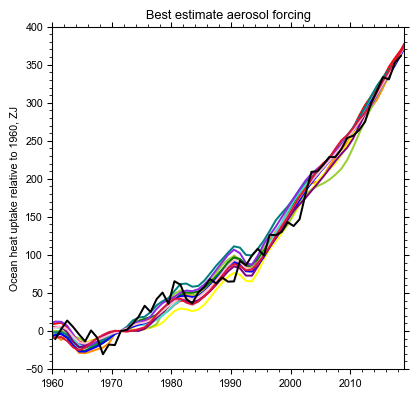

In [84]:
fig, ax = pl.subplots()
for expt in expts:
    ax.plot(np.arange(1750.5,2020), 10*np.nansum((ohc[expt]-ohc[expt][221,:])*ks['multi'][expt], axis=1), color=colors[expt])
ax.set_title('Best estimate aerosol forcing')
ax.set_ylabel('Ocean heat uptake relative to 1960, ZJ')
ax.plot(np.arange(1960.5,2019), (OHCobs-OHCobs[11]), color=colors['observations'])
ax.set_xlim(1960,2019)
ax.set_ylim(-50,400)

In [85]:
# Throw TCR into the mix
tcr = geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg'] + geoff_sample_df[:samples]['eff']*geoff_sample_df[:samples]['gamma_2l'])
ecs = geoff_sample_df['q4x'][:samples]/2/(geoff_sample_df[:samples]['lamg'])

In [87]:
pc = {}
for expt in tqdm_notebook(expts):
    pc[expt] = {}
    for constraint in ['temp', 'ohc', 'multi']:
        pc[expt][constraint] = {}
        pc[expt][constraint]['ECS'] = {}
        pc[expt][constraint]['TCR'] = {}
        for metric in ['GSAT','OHC','ERFari','ERFaci','ERFaer']:
            pc[expt][constraint][metric] = {}
            for perc in ['5','16','50','84','95']:
                pc[expt][constraint][metric][perc] = np.zeros(270)
        (
            pc[expt][constraint]['ECS']['5'],
            pc[expt][constraint]['ECS']['16'],
            pc[expt][constraint]['ECS']['50'],
            pc[expt][constraint]['ECS']['84'],
            pc[expt][constraint]['ECS']['95']
        ) = (
            weighted_percentile(ecs, ks[constraint][expt], [.05,.16,.5,.84,.95])
        )
        (
            pc[expt][constraint]['TCR']['5'],
            pc[expt][constraint]['TCR']['16'],
            pc[expt][constraint]['TCR']['50'],
            pc[expt][constraint]['TCR']['84'],
            pc[expt][constraint]['TCR']['95']
        ) = weighted_percentile(tcr, ks[constraint][expt], [.05,.16,.5,.84,.95])
        for year in range(270):
            (
                pc[expt][constraint]['GSAT']['5'][year],
                pc[expt][constraint]['GSAT']['16'][year],
                pc[expt][constraint]['GSAT']['50'][year],
                pc[expt][constraint]['GSAT']['84'][year],
                pc[expt][constraint]['GSAT']['95'][year] 
            ) = weighted_percentile(temp[expt][year,:] + intvar[year,:samples], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['OHC']['5'][year],
                pc[expt][constraint]['OHC']['16'][year],
                pc[expt][constraint]['OHC']['50'][year],
                pc[expt][constraint]['OHC']['84'][year],
                pc[expt][constraint]['OHC']['95'][year] 
            ) = weighted_percentile(ohc[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['ERFari']['5'][year],
                pc[expt][constraint]['ERFari']['16'][year],
                pc[expt][constraint]['ERFari']['50'][year],
                pc[expt][constraint]['ERFari']['84'][year],
                pc[expt][constraint]['ERFari']['95'][year] 
            ) = weighted_percentile(ERFari[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['ERFaci']['5'][year],
                pc[expt][constraint]['ERFaci']['16'][year],
                pc[expt][constraint]['ERFaci']['50'][year],
                pc[expt][constraint]['ERFaci']['84'][year],
                pc[expt][constraint]['ERFaci']['95'][year] 
            ) = weighted_percentile(ERFaci[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])
            (
                pc[expt][constraint]['ERFaer']['5'][year],
                pc[expt][constraint]['ERFaer']['16'][year],
                pc[expt][constraint]['ERFaer']['50'][year],
                pc[expt][constraint]['ERFaer']['84'][year],
                pc[expt][constraint]['ERFaer']['95'][year] 
            ) = weighted_percentile(ERFari[expt][year,:]+ERFaci[expt][year,:], ks[constraint][expt], [.05,.16,.5,.84,.95])

/nfs/a65/pmcjs/miniconda3/envs/ar6_aerosol/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/13 [00:00<?, ?it/s]

In [88]:
save_dict_to_hdf5(pc, '../data_output/results/pc.h5')